In [1]:
import qutip, pickle, sys
import matplotlib.pyplot as plt 
import numpy as np
import scipy.optimize as opt 
import scipy.linalg as linalg
import time as time
import math, cmath
import Max_Ent_aux_lib as me
#import proj_ev_library as projev
#import max_entev library as meev
from IPython.display import display, Math, Latex

np.set_printoptions(threshold=1.e-3,linewidth=120,precision=1, formatter={"float":lambda x: str(.001*int(1000*x)) })

Tenemos la siguiente ecuación de movimiento:

$$
    \dot{c}_M(t) I_{M}^{0}(t) = -i \bigg\{\bigg(c_{M+2}(t) - c_M(t) \bigg)\langle \rho_{M}^{0\dagger}(t) [H_{0,-2}, \rho_{M+2}^0] \rangle + \bigg(c_{M-2}(t) - c_M(t)\bigg) \langle \rho_{M}^{0\dagger}(t) [H_{0,2}, \rho_{M-2}^0] \rangle + p \langle \rho_{M}^{0\dagger}(t) [\Sigma, \rho_{M}^0 (t)]\rangle \bigg\}
$$

siendo $I_{M}^{0}(t) = \langle \rho_{M}^{0\dagger}(t) \rho_{M}^{0}(t)\rangle = I_{-M}^{0}(t)$
la cual puede reescribirse como 

$$
\dot{c}_M(t) I_{M}^{0}(t) = -i \bigg\{A_{\rho^{M, M+2}} c_{M+2}(t) - \bigg(A_{\rho^{M, M+2}} + B_{\rho^{M, M-2}} \bigg) c_{M}(t) + B_{\rho^{M, M-2}} c_{M-2}(t) \bigg\} + p C_{\rho^M} \\
= - i({\bf{\mathcal{M}}}(t) \textbf{c}(t))_M
$$

donde 

<ol>

<li> $A_{\rho^{M, M+2}} = \langle \rho_{M}^{0\dagger}(t) [H_{0,-2}, \rho_{M+2}^0] \rangle$ </li> 
<li> $B_{\rho^{M, M-2}} = \langle \rho_{M}^{0\dagger}(t) [H_{0,2}, \rho_{M-2}^0] \rangle$ </li>
<li> $C_{\rho^M} = \langle \rho_{M}^{0\dagger}(t) [\Sigma, \rho_{M}^0 (t)]\rangle$ </li>
    
</ol>    

Entonces, si $f(t) = \langle \rho(t) \rho^0(t) \rangle = \sum_{M} {c}_M(t) I_{M}^{0}(t)$

$$
    \dot{f}(t) = \sum_{M} \bigg(\dot{c}_M(t) I_{M}^{0}(t) + {c}_M(t) \dot{I}_{M}^{0}(t) \bigg)
$$

where

1: $A=\alpha B = N(t) \exp(-m t^{1+a}) = I_M^{(0)}$ (a primer orden alpha = 1) \
2: $C = M N(t) exp(-m t^{1+a})$

con $N(t) = 1/Tr(\rho(t))$ la calculo con la definición del $\rho_M (t)=  c_{M}(t) \rho^0_M(t)$, with $c_0(t)$= 1. 
Note that the kernel $K(t,t') = e^{(-i M(t-t'))}$ is not a solution to the previous differential equation for the M-tensor is time-dependent
    
$H_ {0, 2}^\dagger = H_{0, -2}$ 

$\rho_{M}^\dagger = \rho_{-M}$

## Step 1: Fix parameters and initial conditions for the coherences

In [12]:
p = .108;    # strength of the Sigma Interaction Hamiltonian
a = -1;      # Power-law factor
M = 500;        # Truncation/Total no. of coherences
coherences_t0_pert0 = 1. # Unused for the time being
param_list = {"total_no_cohrs": M, "p_factor": p, "power_law_factor": a} # dictionary containing the simulation's initial 
                                                                         # parameters 

cohr_complex_t0 = [(1/M) for i in range(param_list["total_no_cohrs"])] 
    # initial configuration of complex-valued coherences, random numbers for the time being. Can be changed in the future

cohr_complex_t0 += [0 for i in range(param_list["total_no_cohrs"])]
    # normalization of the initial vector, so that Tr c_0 = 1. 
cohr_t0_trace = sum(cohr_complex_t0)
cohr_complex_t0 = [cohr/cohr_t0_trace for cohr in cohr_complex_t0]
cohr_complex_t0 = np.array(cohr_complex_t0)

Since the coherences are complex-valued numbers, the previous system of $M \times M$ coupled complex-valued differential equations can be rewritten as a system of $2M \times 2M$ coupled real-valued differential equations, as follows:

if $c_M(t) = a_M(t) + i b_M(t)$, then 

$$
    \dot{a}_M(t) + i \dot{b}_M(t) = -i \sum_{m'}{\bf{\mathcal{M}}}_{Mm'}(t) \bigg(a_{m'}(t) + i b_{m'}(t)\bigg),
$$

$$
    \dot{a}_M(t) + i \dot{b}_M(t) = -i \sum_{m'}{\bf{\mathcal{M}}}_{Mm'}(t) a_{m'}(t) + \sum_{m'} {\bf{\mathcal{M}}}_{Mm'}(t) b_{m'}(t)
$$

$$
    \dot{{\bf a}}(t) = {\cal M}(t) \cdot {\bf b}(t), \quad \dot{{\bf b}}(t) = -{\cal M}(t) \cdot {\bf a}(t), \qquad s.t. \quad{\bf c}(t) = {\bf a}(t) + i {\bf b}(t)
$$


## Step 2: Setting up and Solving system of complex diff. eqs

In [13]:
param_list = {"total_no_cohrs": M, "p_factor": p, "power_law_factor": a} # dictionary containing the simulation's initial 
                                                                         # parameters 

cohr_complex_t0 = [1 for i in range(param_list["total_no_cohrs"])]
cohr_complex_t0 += [1 for i in range(param_list["total_no_cohrs"])]
cohr_complex_t0 = np.array(cohr_complex_t0)
param_list = [M, p, -1]

In [14]:
type(np.array([1]))

numpy.ndarray

In [15]:
B = me.complex_differential_system(parameters = param_list, cohr_complex = cohr_complex_t0, t=1)
len(B)

1000

In [16]:
Mmatrix = me.Mtensor_2mx2m_dimensional_symplectic(parameters = param_list, init_configurations = cohr_complex_t0, timet=3, as_qutip_qobj = False)
qutip.Qobj(Mmatrix)

Quantum object: dims = [[1000], [1000]], shape = (1000, 1000), type = oper, isherm = True
Qobj data =
[[0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]]

In [17]:
.5 * (qutip.Qobj(Mmatrix) + qutip.Qobj(Mmatrix).dag())

Quantum object: dims = [[1000], [1000]], shape = (1000, 1000), type = oper, isherm = True
Qobj data =
[[0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 ...
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]
 [0.0 0.0 0.0 ... 0.0 0.0 0.0]]

In [19]:
from scipy.integrate import odeint
tmax = 20; no_steps = 500
ts = np.linspace(0.1, tmax, no_steps)              ## times 
time_ev_ReIm_cohrs = odeint(func = me.complex_differential_system, 
                y0 = cohr_complex_t0, 
                t = ts,
                args = ((param_list,)))
#  tiempo vertical, primera linea es la config init: t  cohr
# cohr[t][m] = coherencia a tiempo t número m
time_ev_ReIm_cohrs 

array([[1.0, 1.0, 1.0, ..., 1.0, 1.0, 1.0],
       [1.2, 0.861, 1.07, ..., 1.04, 1.04, 1.04],
       [1.389, 0.8290000000000001, 1.11, ..., 1.083, 1.082, 1.083],
       ...,
       [2.9369275623770448e+19, 1.045532824025875e+19, 9.10664050586951e+18, ..., 405067717.778, 403746553.01,
        407411042.992],
       [3.2109923454308758e+19, 1.143098636778091e+19, 9.956443373010313e+18, ..., 421547322.575, 420171472.846,
        423989971.96000004],
       [3.510631988111256e+19, 1.249768979037245e+19, 1.0885547175382966e+19, ..., 438697376.486, 437264583.625,
        441243549.748]])

In [20]:
# Revisar la hermiticidad de la matriz. 

In [21]:
### Test
assert len(time_ev_ReIm_cohrs) == no_steps
assert len(time_ev_ReIm_cohrs[1]) == 2*M

## Step 3: Obtaining the time-evolved complex-valued coherences


Ideally, the observables of interest obtained via our coherences should show this trend 

<img src="PhD%20Physics/2nd%20Year/RMN-Max-Ent/Decoherence_..._scrambling_Dominguez_ib_observables" width=60 height=60 />

In [22]:
complex_cohrs_at_time_t = [[time_ev_ReIm_cohrs[list(ts).index(t)][m] + 1j*time_ev_ReIm_cohrs[list(ts).index(t)][m+M] for m in range(M)] for t in ts]
complex_cohrs_at_time_t = np.array(complex_cohrs_at_time_t)

In [23]:
complex_cohrs_at_time_t[0]

array([1.+1.j, 1.+1.j, 1.+1.j, ..., 1.+1.j, 1.+1.j, 1.+1.j])

In [24]:
#fidelity_at_time_t = [sum(complex_cohrs_at_time_t[list(ts).index(t)] * A_mmplustwo_matrix_elmt(cohrnc, time, power_law_factor = .5)
#   
#    list(ts).index(t)]) for t in ts]

Entonces, si

$$
    f(t) = \langle \rho(t) \rho^0(t) \rangle = \sum_{M}{c}_M(t) I_{M}^{0}(t)
$$

then

$$
    \dot{f}(t) = \sum_{M} \bigg(\dot{c}_M(t) I_{M}^{0}(t) + {c}_M(t) \dot{I}_{M}^{0}(t) \bigg)
$$

In [25]:
#complex_cohrs_at_time_t[99][599]

In [26]:
fidelity_at_timet = []
timespan = list(ts)

for t in ts[1:]:
    local_list = complex_cohrs_at_time_t[timespan.index(t)]
    for m in range(M):
        local_val = 0
        local_val += local_list[m] * me.A_mmplustwo_matrix_elmt(cohrnc = m, time = timespan.index(t), power_law_factor = a)
        m +=1 
    fidelity_at_timet.append(local_val)
    local_val = 0
    
assert len(fidelity_at_timet) == len(ts)-1

In [27]:
len(ts)

500

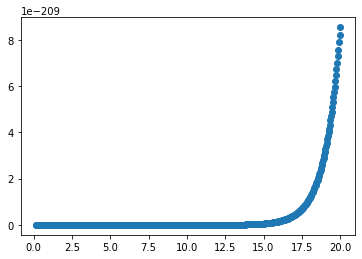

In [28]:
plt.scatter(ts[1:], np.real(fidelity_at_timet))


# Tests y fallos :(

## Test: $a$ = -1

In [14]:
fidelity_vs_t = [[sum(result[:, m][int(list(ts).index(t)) 
                                   * -m * (a+1) * t**a / (me.A_mmplustwo_matrix_elmt(m, t, a))] for m in range(M))] for t in list(ts)]

NameError: name 'result' is not defined

In [72]:
len(result[:, 0])

100

In [13]:
fidelity_t0 = []

In [23]:
Preguntas:
    
    1. La matrix M tiene que depender con el tiempo me parece, si A, B y C lo hacen: Check 
    2. Como tendría que implementar la norma???: Check
    3. Empezar a jugar con los parámetros: Checkn't
    
m+2 vs m+2 : Check
** reescribir la matriz en tèrminos de los c_pares. : Check

SyntaxError: invalid syntax (3991330021.py, line 1)

In [73]:
len(result[0])

6